<a href="https://colab.research.google.com/github/KacperGrodecki/image_proccessing/blob/main/kuba_img_text_reading_found_words_analyzing_enchant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip uninstall spacy

Found existing installation: spacy 2.3.2
Uninstalling spacy-2.3.2:
  Would remove:
    /usr/local/bin/spacy
    /usr/local/lib/python3.7/dist-packages/bin/*
    /usr/local/lib/python3.7/dist-packages/spacy-2.3.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/spacy/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/bin/theano_cache.py
Proceed (y/n)? y
  Successfully uninstalled spacy-2.3.2


In [1]:
pip install spacy==2.3.2

In [2]:
!python3 -m spacy download pl_core_news_md
#https://github.com/explosion/spaCy/issues/5140

     |████████████████████████████████| 79.9 MB 1.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_md')


In [3]:
import spacy  
from spacy.lang.pl.examples import sentences 
nlp = spacy.load("pl_core_news_md")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pip install pyenchant

     |████████████████████████████████| 55 kB 2.1 MB/s 


In [6]:
!apt install -qq enchant

The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,312 kB of archives.
After this operation, 5,353 kB of additional disk space will be used.
Preconfiguring packages ...
Selecting previously unselected package libtext-iconv-perl.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../0-libtext-iconv-perl_1.7-5build6_amd64.deb ...
Unpacking libtext-iconv-perl (1.7-5build6) ...
Selecting previously unselected package libaspe

In [7]:
!apt-get install myspell-pl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libreoffice
The following NEW packages will be installed:
  myspell-pl
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 925 kB of archives.
After this operation, 4,827 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 myspell-pl all 20170707-1 [925 kB]
Fetched 925 kB in 1s (917 kB/s)
Selecting previously unselected package myspell-pl.
(Reading database ... 155633 files and directories currently installed.)
Preparing to unpack .../myspell-pl_20170707-1_all.deb ...
Unpacking myspell-pl (20170707-1) ...
Setting up myspell-pl (20170707-1) ...
Processing triggers for dictionaries-common (1.27.2) ...


In [8]:
import pandas as pd
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt      
import pickle
from os import listdir
from os.path import isfile, join
import gc
import sys
import pickle
import string
import enchant
from time import time
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency
import multiprocessing
from gensim.models import Word2Vec

In [9]:
d = enchant.Dict('PL')
d.check("guzik") # False



True

In [10]:
text=pd.read_csv('drive/MyDrive/kuba/odczyt_0_85.csv',index_col=0)

In [11]:
text.head()

,0
0,drive/MyDrive/kuba/zdjecia/fig1.jpg
1,Własność\narchiwum\nAktotwórca\nTytuł teczki\n...
2,IPN BU 0 639/223
3,KARTA INFORMACYJNA
4,Instytut Pamięci Narodowej w Warszawie


In [12]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [13]:
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

In [14]:
ch='/'
ch.isalnum()

False

In [15]:
import re

In [16]:
def word_correction_enchant(a):
    a=str(a)
    if 'drive/MyDrive/kuba/' in a:
      return a
    correct=''
    for word in a.split():
        word=re.sub(r'\W+', '', word)
        word = ''.join(ch for ch in word if ch.isalnum())
        if len(word)>1:
            if has_numbers(word) or len(word)<3:
              continue
            try:
              if int(d.check(word))==1:
                correct+=word.lower()+' '
            except:
              pass     
    return correct

In [17]:
correct=text.applymap(lambda x: word_correction_enchant(x))#dodać numery stron

In [18]:
correct1 = correct[correct['0']!= '']

In [19]:
print(correct1.shape)

(9623, 1)


In [20]:
kuba=correct1.copy()

In [21]:
#https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [22]:
df=correct1.copy()

In [23]:
df.head()

,0
0,drive/MyDrive/kuba/zdjecia/fig1.jpg
1,własność archiwum tytuł teczki daty skrajne je...
2,ipn
3,karta informacyjna
4,instytut pamięci narodowej warszawie


In [24]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
     return ' '.join(txt)

In [44]:
brief_cleaning = (str(row).lower() for row in df['0'])

In [45]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.13 mins


In [46]:
print(txt)

['drive / mydrive / kuba / zdjecia / fig1.jpg', 'własność archiwum tytuł teczka data skrajny jednostka archiwalny stary sygnatura sygnatura archiwalny', None, None, 'instytut pamięć narodowy warszawa', None, None, 'pax materiał dotyczyć działalność zrzeszenie', None, None, None, None, None, None, 'drive / mydrive / kuba / zdjecia / fig10.jpg', 'struktura wykonanie budżet', 'katolicki organizacja społeczny', 'pax kik rok', None, 'realizacja budżet rok', None, 'pokrycie strata prasa wydawnictwo', None, None, None, 'płaca osobowy fundusz płaca', None, None, None, 'podróża służbowy delegacja', 'koszt biurowy utrzymanie', None, None, None, None, None, None, 'zespół akcja działalność', None, 'pokrycie strata prasa wydać', None, None, None, None, 'wpłata nadwyżka całokształt', None, 'drive / mydrive / kuba / zdjecia / fig100.jpg', None, 'pogłębiać trudność powodować', None, None, 'biskup księża konserwatysta', None, 'kierunek zmiana statutowy wskazywać potrzeba', 'wysoki ranga zespół', 'dział

In [47]:
nlp_txt=''.join(str([row for row in df['0']]))
doc = nlp(nlp_txt)

In [48]:
#https://realpython.com/natural-language-processing-spacy-python/#part-of-speech-tagging
surnames=[]
for token in doc:
  if token.pos_=='NOUN' and ('ski' in token.text or 'cki' in token.text):
    surnames.append(token.text)
print(set(surnames))

{'pozyskiwania', 'prusiński', 'frankowski', 'drozdowski', 'kudliński', 'gołębiewski', 'rekowski', 'skierowanie', 'wójcicki', 'morawskiego', 'dąbrowskiego', 'wrocławski', 'balicki', 'naciski', 'troski', 'różycki', 'ziembiński', 'piasecki', 'zagórski', 'lipiński', 'jabłoński', 'wyszyńskiego', 'brodowskiego', 'brodowski', 'rostworowski', 'markowski', 'staszowski', 'sułkowski', 'zielonogórskiego', 'szczepanowski', 'łaski', 'dybowski', 'wyszyński', 'czajkowski', 'uzyskiwania', 'morawski', 'wnioski', 'piaseckim', 'jankowski', 'stanowiskiem', 'uzyskiwanie', 'polski', 'ski', 'janicki', 'zjawiskiem', 'piaseckiego', 'dębski', 'czajkowskiego', 'gąsowski', 'jaroszewskiego', 'skierowania', 'moczyński', 'markowskiego'}


In [49]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=5, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [50]:
df_clean.head()

,clean
0,drive / mydrive / kuba / zdjecia / fig1.jpg
1,własność archiwum tytuł teczka data skrajny je...
4,instytut pamięć narodowy warszawa
7,pax materiał dotyczyć działalność zrzeszenie
14,drive / mydrive / kuba / zdjecia / fig10.jpg


In [51]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

5590

In [52]:
surnames_freq = defaultdict(int)
for sent in surnames:
        surnames_freq[sent] += 1
len(surnames_freq)

53

In [53]:
sorted(surnames_freq, key=surnames_freq.get, reverse=True)[:20]

['polski',
 'wyszyński',
 'czajkowski',
 'wnioski',
 'uzyskiwania',
 'uzyskiwanie',
 'piaseckiego',
 'łaski',
 'rekowski',
 'lipiński',
 'frankowski',
 'sułkowski',
 'piasecki',
 'jaroszewskiego',
 'czajkowskiego',
 'dąbrowskiego',
 'stanowiskiem',
 'zagórski',
 'kudliński',
 'drozdowski']

In [54]:
sorted(word_freq, key=word_freq.get, reverse=True)[4:10]

['praca', 'pax', 'człowiek', 'działalność', 'stowarzyszenie', 'sprawa']

In [55]:
pd_word_freq=pd.DataFrame.from_dict(word_freq, orient='index')
pd_word_freq_sorted=pd_word_freq.sort_values(by=[0], ascending=False)

In [56]:
cores = multiprocessing.cpu_count()

In [57]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [58]:
t = time()

w2v_model.build_vocab(sentences, progress_per=100)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [59]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.06 mins


In [60]:
w2v_model.init_sims(replace=True)

In [61]:
w2v_model.wv.most_similar(positive=["piasecki"])

[('pax', 0.99993497133255),
 ('sytuacja', 0.999931812286377),
 ('zostać', 0.9999309778213501),
 ('praca', 0.9999282360076904),
 ('uchwała', 0.9999277591705322),
 ('polsce', 0.9999269247055054),
 ('projekt', 0.9999262094497681),
 ('stowarzyszenie', 0.9999260306358337),
 ('produkcja', 0.9999251365661621),
 ('referat', 0.9999237060546875)]

In [62]:
w2v_model.wv.most_similar(positive=["pax"])

[('praca', 0.9999566078186035),
 ('produkcja', 0.9999533891677856),
 ('stowarzyszenie', 0.9999527931213379),
 ('sytuacja', 0.999951958656311),
 ('uchwała', 0.9999518990516663),
 ('polsce', 0.9999505281448364),
 ('nasz', 0.9999490976333618),
 ('społeczeństwo', 0.9999480247497559),
 ('projekt', 0.999947190284729),
 ('związek', 0.9999463558197021)]

In [63]:
w2v_model.wv.most_similar(positive=["radziecki"])

[('praca', 0.999911367893219),
 ('pax', 0.999909520149231),
 ('produkcja', 0.9999086856842041),
 ('uchwała', 0.9999073147773743),
 ('polsce', 0.9999046921730042),
 ('nasz', 0.9999033808708191),
 ('kraj', 0.9999020099639893),
 ('stowarzyszenie', 0.9999018907546997),
 ('tytuł', 0.9999017119407654),
 ('sytuacja', 0.9999008178710938)]

In [64]:
w2v_model.wv.most_similar(positive=["kościół"])

[('pax', 0.9999294877052307),
 ('produkcja', 0.9999294281005859),
 ('uchwała', 0.9999279975891113),
 ('projekt', 0.9999278783798218),
 ('praca', 0.9999275207519531),
 ('zostać', 0.9999274015426636),
 ('sytuacja', 0.999925971031189),
 ('stowarzyszenie', 0.9999255537986755),
 ('polsce', 0.9999253153800964),
 ('społeczeństwo', 0.9999243021011353)]

In [65]:
w2v_model.wv.most_similar(negative=["kościół"])

[('zjednoczenie_przemysł', -0.995842456817627),
 ('podać', -0.9990570545196533),
 ('aaa', -0.9992574453353882),
 ('wyrób', -0.9993451833724976),
 ('pracować', -0.9994069933891296),
 ('przemysł', -0.9995054006576538),
 ('stworzenie', -0.9995212554931641),
 ('linia', -0.9995782375335693),
 ('tzn', -0.9996738433837891),
 ('hasło', -0.9996767044067383)]

In [72]:
w2v_model.wv.doesnt_match(['pax', 'pracować', 'kościół','polska','katolicki'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'pracować'

In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [68]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=18).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

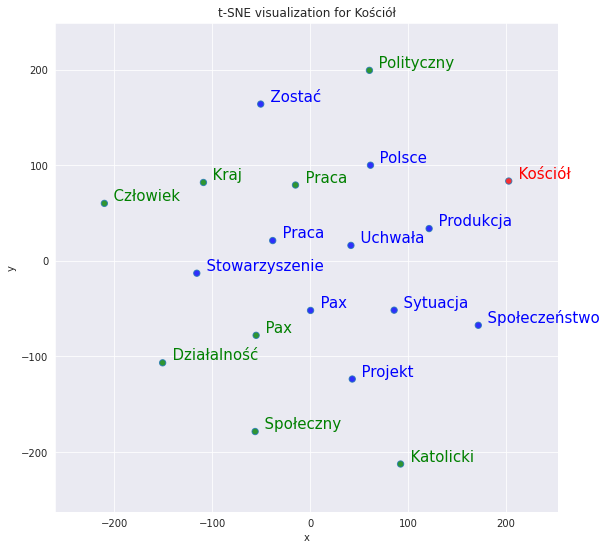

In [69]:
tsnescatterplot(w2v_model, 'kościół', ['praca', 'działalność', 'człowiek', 'polityczny', 'kraj', 'pax', 'społeczny','katolicki'])

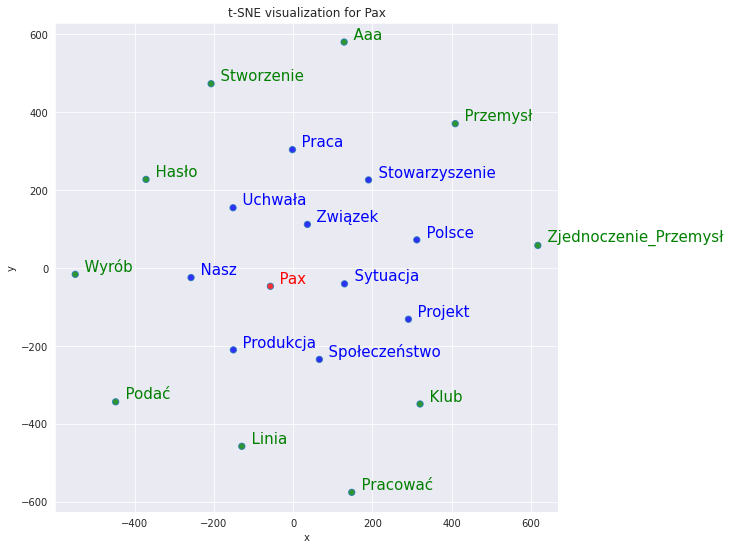

In [80]:
tsnescatterplot(w2v_model, 'pax', [i[0] for i in w2v_model.wv.most_similar(negative=["pax"])])

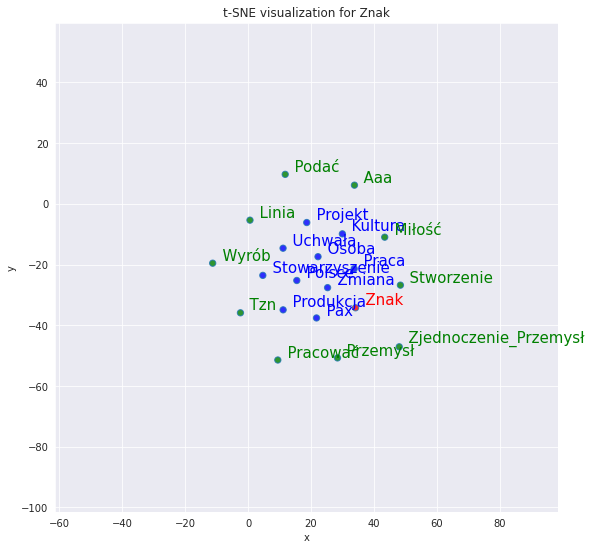

In [81]:
tsnescatterplot(w2v_model, 'znak', [i[0] for i in w2v_model.wv.most_similar(negative=["znak"])])